# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
#import os
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
#import keras.backend as K
from keras.callbacks import History 
from tensorflow.python.keras.utils import to_categorical

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = cv2.imread(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(5237, 32, 20, 3)
(5237, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Epoch_Anz = 80
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle,
                             validation_split=0.2)

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


Instructions for updating:
Use tf.cast instead.
Epoch 1/80
1048/1048 [==============================] - 23s 22ms/step - loss: 0.3882 - acc: 0.8880 - val_loss: 0.1610 - val_acc: 0.9580
Epoch 2/80
1048/1048 [==============================] - 23s 22ms/step - loss: 0.1209 - acc: 0.9618 - val_loss: 0.0939 - val_acc: 0.9771
Epoch 3/80
1048/1048 [==============================] - 24s 23ms/step - loss: 0.0899 - acc: 0.9747 - val_loss: 0.0838 - val_acc: 0.9781
Epoch 4/80
1048/1048 [==============================] - 26s 25ms/step - loss: 0.0773 - acc: 0.9780 - val_loss: 0.0956 - val_acc: 0.9704
Epoch 5/80
1048/1048 [==============================] - 28s 27ms/step - loss: 0.0752 - acc: 0.9771 - val_loss: 0.0366 - val_acc: 0.9866
Epoch 6/80
1048/1048 [==============================] - 36s 34ms/step - loss: 0.0716 - acc: 0.9799 - val_loss: 0.0483 - val_acc: 0.9857
Epoch 7/80
1048/1048 [==============================] - 30s 29ms/step - loss: 0.0631 - acc: 0.9826 - val_loss: 0.0545 - val_acc: 0.9838


Epoch 37/80
1048/1048 [==============================] - 24s 23ms/step - loss: 0.0192 - acc: 0.9957 - val_loss: 0.0267 - val_acc: 0.9952
Epoch 38/80
1048/1048 [==============================] - 25s 24ms/step - loss: 0.0243 - acc: 0.9940 - val_loss: 0.0341 - val_acc: 0.9952
Epoch 39/80
1048/1048 [==============================] - 24s 23ms/step - loss: 0.0261 - acc: 0.9947 - val_loss: 0.0199 - val_acc: 0.9943
Epoch 40/80
1048/1048 [==============================] - 25s 24ms/step - loss: 0.0204 - acc: 0.9952 - val_loss: 0.0404 - val_acc: 0.9952
Epoch 41/80
1048/1048 [==============================] - 26s 25ms/step - loss: 0.0245 - acc: 0.9943 - val_loss: 0.0132 - val_acc: 0.9971
Epoch 42/80
1048/1048 [==============================] - 27s 26ms/step - loss: 0.0219 - acc: 0.9947 - val_loss: 0.0303 - val_acc: 0.9924
Epoch 43/80
1048/1048 [==============================] - 23s 22ms/step - loss: 0.0183 - acc: 0.9955 - val_loss: 0.0693 - val_acc: 0.9895
Epoch 44/80
1048/1048 [==================

Epoch 74/80
1048/1048 [==============================] - 24s 23ms/step - loss: 0.0157 - acc: 0.9957 - val_loss: 0.0152 - val_acc: 0.9971
Epoch 75/80
1048/1048 [==============================] - 23s 22ms/step - loss: 0.0205 - acc: 0.9957 - val_loss: 0.0213 - val_acc: 0.9981
Epoch 76/80
1048/1048 [==============================] - 23s 22ms/step - loss: 0.0214 - acc: 0.9962 - val_loss: 0.0226 - val_acc: 0.9952
Epoch 77/80
1048/1048 [==============================] - 24s 23ms/step - loss: 0.0119 - acc: 0.9981 - val_loss: 0.0120 - val_acc: 0.9990
Epoch 78/80
1048/1048 [==============================] - 27s 26ms/step - loss: 0.0264 - acc: 0.9962 - val_loss: 0.0381 - val_acc: 0.9943
Epoch 79/80
1048/1048 [==============================] - 28s 27ms/step - loss: 0.0138 - acc: 0.9971 - val_loss: 0.0359 - val_acc: 0.9952
Epoch 80/80
1048/1048 [==============================] - 28s 27ms/step - loss: 0.0097 - acc: 0.9981 - val_loss: 0.0261 - val_acc: 0.9933


### Learing result
 
* Visualization of the training and validation results

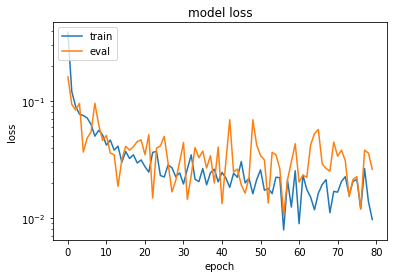

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

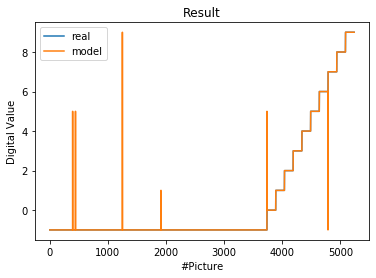

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = cv2.imread(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [9]:
model.save("Train_CNN_Digital-Readout_Version2.h5")

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [8]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = cv2.imread(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/6\Ziffer_6_0150.jpg 6 NaN
ziffer_sortiert_resize/NaN\Ziffer_NaN_0394.jpg NaN 5
ziffer_sortiert_resize/NaN\Ziffer_NaN_0442.jpg NaN 5
ziffer_sortiert_resize/NaN\Ziffer_NaN_0443.jpg NaN 5
ziffer_sortiert_resize/NaN\Ziffer_NaN_1250.jpg NaN 9
ziffer_sortiert_resize/NaN\Ziffer_NaN_1912.jpg NaN 1
ziffer_sortiert_resize/NaN\Ziffer_NaN_1913.jpg NaN 1
ziffer_sortiert_resize/NaN\Ziffer_NaN_1914.jpg NaN 1
ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.